In [1]:
#Import all necessary pacakages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Method definition


def MissigdataPercent(train_Data, nrows):
	total = train_Data.isnull().sum().sort_values(ascending=False)
	percent = (train_Data.isnull().sum()/train_Data.isnull().count()).sort_values(ascending=False)
	missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
	return missing_data.head(nrows) 



def Missigdatagraph(missing_values):
    missing_values = missing_values.isnull().sum(axis=0).reset_index()
    missing_values.columns = ['column_name', 'missing_count']
    missing_values = missing_values.loc[missing_values['missing_count']>0]
    missing_values = missing_values.sort_values(by='missing_count')
    
    ind = np.arange(missing_values.shape[0])
    width = 0.1
    fig, ax = plt.subplots(figsize=(12,3))
    rects = ax.barh(ind, missing_values.missing_count.values, color='b')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
    ax.set_xlabel("Missing Observations Count")
    ax.set_title("Missing Observations Count - Features")
    plt.show()
    
    
def remove_outlier(df_in, col):
    q1 = df_in[col].quantile(0.25)
    q3 = df_in[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col] > fence_low) & (df_in[col] < fence_high)] 
    return df_out


def fixSkewness(column , columnval):
    sns.distplot(column)
    sns.boxplot(x=column)
    print("Skewness of column %s : %f" % (columnval, column.skew()))
    
    
def correlation_heatmap(df, title):
    _ , ax = plt.subplots(figsize =(14, 12))
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask, k = 1)] = True
    colormap = sns.diverging_palette(10, 150, as_cmap = True, s = 99, l = 60)
    
    if(df.corr().min().min() < 0):    
        colormap = sns.diverging_palette(10, 150, as_cmap = True, s = 99, l = 60)
        mid_val = 0
    else:
        colormap = sns.light_palette((150, 99, 60), as_cmap=True, input='husl')
        mid_val = None   
        
    _ = sns.heatmap(
        df.corr(), 
        mask = mask,
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 },
        ax=ax,
        annot=True,
        linewidths=0.1, vmax=1.0, linecolor='white',
        center = mid_val,
        annot_kws = {'fontsize': 9 }
    )
    
    plt.title(title, y=1.05, size=15)
    
def LabelEncode(dataset_to_encode, columns):
    for c in columns:
        labelencoder = LabelEncoder()
        dataset_to_encode[c] = labelencoder.fit_transform(dataset_to_encode[c].astype(str))
        dataset_to_encode[c] = dataset_to_encode[c].astype(int)

In [3]:
#Read the file from the given path

file_path = "loan.csv"
df_loan = pd.read_csv(file_path, dtype={"next_pymnt_d": object})

# Exploratory  Data  Analaysis 

In [4]:
#print number of rows and columns

original_dataset = df_loan.shape
print('#Number of Rows & Columns in the source file:',df_loan.shape)
print('\n')
print(df_loan.head())

#Number of Rows & Columns in the source file: (39717, 111)


        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   
1   15.27%        59.83     C        C4  ...                NaN   
2   15.96%        84.33     C        C5  ...                NaN   
3   13.49%       339.31     C        C1  ...                NaN   
4   12.69%        67.79     B        B5  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankr

In [5]:
# describe loan dataframe

print(df_loan.describe())

                 id     member_id     loan_amnt   funded_amnt  \
count  3.971700e+04  3.971700e+04  39717.000000  39717.000000   
mean   6.831319e+05  8.504636e+05  11219.443815  10947.713196   
std    2.106941e+05  2.656783e+05   7456.670694   7187.238670   
min    5.473400e+04  7.069900e+04    500.000000    500.000000   
25%    5.162210e+05  6.667800e+05   5500.000000   5400.000000   
50%    6.656650e+05  8.508120e+05  10000.000000   9600.000000   
75%    8.377550e+05  1.047339e+06  15000.000000  15000.000000   
max    1.077501e+06  1.314167e+06  35000.000000  35000.000000   

       funded_amnt_inv   installment    annual_inc           dti  \
count     39717.000000  39717.000000  3.971700e+04  39717.000000   
mean      10397.448868    324.561922  6.896893e+04     13.315130   
std        7128.450439    208.874874  6.379377e+04      6.678594   
min           0.000000     15.690000  4.000000e+03      0.000000   
25%        5000.000000    167.020000  4.040400e+04      8.170000   
50%   

### Data Cleaning on Columns ans Rows


In [6]:
# check if there are any null values available 
print(df_loan.isnull().sum())

id                                    0
member_id                             0
loan_amnt                             0
funded_amnt                           0
funded_amnt_inv                       0
term                                  0
int_rate                              0
installment                           0
grade                                 0
sub_grade                             0
emp_title                          2459
emp_length                         1075
home_ownership                        0
annual_inc                            0
verification_status                   0
issue_d                               0
loan_status                           0
pymnt_plan                            0
url                                   0
desc                              12940
purpose                               0
title                                11
zip_code                              0
addr_state                            0
dti                                   0


In [7]:
# Dropping columns with all null values
df_loan.dropna(axis = 1, how ='all', inplace = True) 

In [8]:
print('New dataframe "rows, columns":' , df_loan.shape)

New dataframe "rows, columns": (39717, 57)


In [9]:
# check if there are any null values available
#Get Top missing values
MissigdataPercent(df_loan, 15)

,Total,Percent
next_pymnt_d,38577,0.971297
mths_since_last_record,36931,0.929854
mths_since_last_delinq,25682,0.646625
desc,12940,0.325805
emp_title,2459,0.061913
emp_length,1075,0.027066
pub_rec_bankruptcies,697,0.017549
last_pymnt_d,71,0.001788
chargeoff_within_12_mths,56,0.001410
collections_12_mths_ex_med,56,0.001410


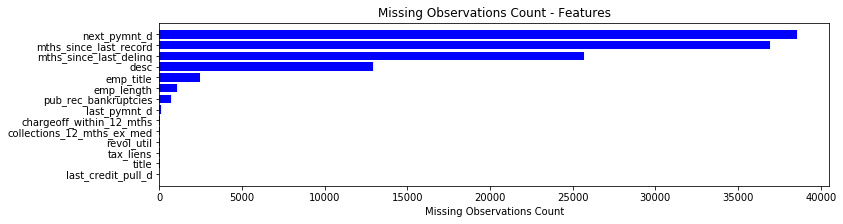

In [10]:
#Get Top missing values
Missigdatagraph(df_loan)

In [11]:
#Getting Columns having more than 50% missing value
missing_val = MissigdataPercent(df_loan, 15)
missing_val[missing_val.Percent>=0.5].index

# Dropping columns with highest NA values - more than 50% in actual dataset
df_loan.drop(labels = list(missing_val[missing_val.Percent>=0.5].index), axis =1, inplace=True)
print('New dataframe "rows, columns":' , df_loan.shape)

New dataframe "rows, columns": (39717, 54)


In [12]:
# Dropping columns with string values which cannot be filled in with dummy values for analysis
df_loan = df_loan.drop(["desc", "emp_title", "title"], axis=1)
print("So now we are left with",df_loan.shape ,"rows & columns.")

So now we are left with (39717, 51) rows & columns.


In [13]:
#Identifying list of columns has unique value
unique = (df_loan.nunique() == 1)
unique = unique[unique]
unique

pymnt_plan                    True
initial_list_status           True
collections_12_mths_ex_med    True
policy_code                   True
application_type              True
acc_now_delinq                True
chargeoff_within_12_mths      True
delinq_amnt                   True
tax_liens                     True
dtype: bool

In [14]:
#Analysing those unique value columns
#df_loan[["tax_liens","delinq_amnt","chargeoff_within_12_mths","acc_now_delinq", "application_type","policy_code","collections_12_mths_ex_med", "initial_list_status", "pymnt_plan"]].astype('category').describe()
df_loan[list(unique.index)].astype('category').describe()

,pymnt_plan,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,tax_liens
count,39717,39717,39661.0,39717,39717,39717,39661.0,39717,39678.0
unique,1,1,1.0,1,1,1,1.0,1,1.0
top,n,f,0.0,1,INDIVIDUAL,0,0.0,0,0.0
freq,39717,39717,39661.0,39717,39717,39717,39661.0,39717,39678.0


**Noticed** all the above 9 columns either have 99.9+ Percent unique value and remaining in NaN.
Since it has only unique values it will not helpful in correlation between attributes.
Safely we can drop these columns

In [15]:
#Dropping the 9 columns from loan dataframe which has only one unique values
df_loan.drop(labels = list(unique.index), axis =1, inplace=True)
print("So now we are left with",df_loan.shape ,"rows & columns.")

So now we are left with (39717, 42) rows & columns.


In [16]:
#Get Top missing values
MissigdataPercent(df_loan, 10)


,Total,Percent
emp_length,1075,0.027066
pub_rec_bankruptcies,697,0.017549
last_pymnt_d,71,0.001788
revol_util,50,0.001259
last_credit_pull_d,2,0.000050
funded_amnt,0,0.000000
member_id,0,0.000000
purpose,0,0.000000
url,0,0.000000
loan_status,0,0.000000


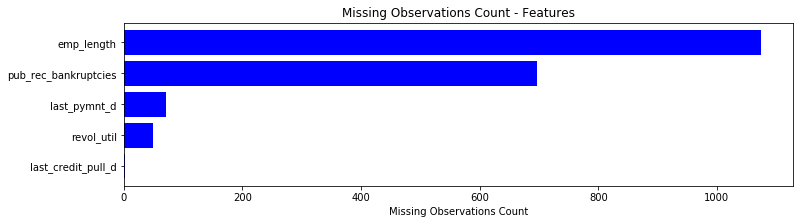

In [17]:
#Get Top missing values
Missigdatagraph(df_loan)

In [18]:
#Analysing "pub_rec_bankruptcies" column
df_loan.pub_rec_bankruptcies.astype('category').describe()

count     39020.0
unique        3.0
top           0.0
freq      37339.0
Name: pub_rec_bankruptcies, dtype: float64

In [19]:
#Imputing NaN to most frequent value 0.0
df_loan[['pub_rec_bankruptcies']] = df_loan[['pub_rec_bankruptcies']].fillna(value=0)

In [20]:
#Get Top missing values
MissigdataPercent(df_loan, 5)

,Total,Percent
emp_length,1075,0.027066
last_pymnt_d,71,0.001788
revol_util,50,0.001259
last_credit_pull_d,2,0.000050
purpose,0,0.000000


```emp_length``` has 2.7% missing value which can't be imputed from the other values.
It is safe to drop those 3% of rows since we have still enough data

In [21]:
#Analysing emp_length column
print(df_loan['emp_length'].value_counts())
print('#NaN Rows:' , df_loan['emp_length'].isnull().sum())

10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: emp_length, dtype: int64
#NaN Rows: 1075


In [22]:
#Imputing NaN to < 1 year
df_loan[['emp_length']] = df_loan[['emp_length']].fillna(value='< 1 year')
print(df_loan['emp_length'].value_counts())
print('#NaN Rows:' , df_loan['emp_length'].isnull().sum())

10+ years    8879
< 1 year     5658
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: emp_length, dtype: int64
#NaN Rows: 0


In [23]:
#Converting string to int
df_loan['emp_length'] = list(map(lambda sub:int(''.join( 
      [ele for ele in sub if ele.isnumeric()])), df_loan['emp_length'])) 

In [24]:
print(df_loan['emp_length'].value_counts())

1     8898
10    8879
2     4388
3     4095
4     3436
5     3282
6     2229
7     1773
8     1479
9     1258
Name: emp_length, dtype: int64


In [25]:
#Get Top missing values
MissigdataPercent(df_loan, 5)

,Total,Percent
last_pymnt_d,71,0.001788
revol_util,50,0.001259
last_credit_pull_d,2,0.000050
emp_length,0,0.000000
purpose,0,0.000000


In [26]:
#Analysing "revol_util" column
df_loan.revol_util.describe()

count     39667
unique     1089
top          0%
freq        977
Name: revol_util, dtype: object

In [27]:
#Imputing NaN to most frequent value 0%
df_loan[['revol_util']] = df_loan[['revol_util']].fillna(value='0%')

In [28]:
#Get Top missing values
MissigdataPercent(df_loan, 5)

,Total,Percent
last_pymnt_d,71,0.001788
last_credit_pull_d,2,0.000050
emp_length,0,0.000000
zip_code,0,0.000000
purpose,0,0.000000


In [29]:
# removing NaN rows in last_pymnt_d & last_credit_pull_d as count is less and imputing might aggregate data
#Since count is less we are safe remove those rows
df_loan = df_loan[~pd.isnull(df_loan['last_pymnt_d'])]
df_loan = df_loan[~pd.isnull(df_loan['last_credit_pull_d'])]

In [30]:
#Get Top missing values
MissigdataPercent(df_loan, 5)

,Total,Percent
pub_rec_bankruptcies,0,0.0
emp_length,0,0.0
zip_code,0,0.0
purpose,0,0.0
url,0,0.0


Now all the missing values handling has been ```completed```

Next remove the duplicate rows

In [31]:
#drop duplicates rows
df_loan.drop_duplicates()
print(df_loan.shape)
# fraction of rows lost
print('DeDuplicate data removed fraction:', round(((1-(len(df_loan.index)/39717)) *100),2),'%')

(39644, 42)
DeDuplicate data removed fraction: 0.18 %


In [32]:
#URL columns analysis
print(df_loan.url.str.split('=', expand=True).head())
print('\n')
print(df_loan.url.str.split('=', expand=True)[0].unique())

                                                   0        1
0  https://lendingclub.com/browse/loanDetail.acti...  1077501
1  https://lendingclub.com/browse/loanDetail.acti...  1077430
2  https://lendingclub.com/browse/loanDetail.acti...  1077175
3  https://lendingclub.com/browse/loanDetail.acti...  1076863
4  https://lendingclub.com/browse/loanDetail.acti...  1075358


['https://lendingclub.com/browse/loanDetail.action?loan_id']


In URL when we splitted by ```=``` noticed first part is unique for all rows and final number looks like ID values.
Lets double whether it is same as ID columns. If yes, then URL columns won't help then we can drop that column

In [33]:
#Comparing URL ID with actual ID to find whether it is same
(df_loan['id'] != df_loan['url'].str.split('=',expand=True)[1].astype(int)).sum()

0

ID and URL last value are identical. Also first part of URL from same domain and page.
So we can drop the ```URL```

In [34]:
# Dropping URL columns as it is not useful for any analysis
df_loan = df_loan.drop([ "url"], axis=1)

In [35]:
print("So now we are left with",df_loan.shape ,"rows & columns.")

So now we are left with (39644, 41) rows & columns.


#### Standardising Columns

In [36]:
#Converting term values from string to int by remvoing month string
df_loan['term'] = df_loan['term'].str.split(' ',expand=True)[1].astype(int)

#Converting "int_rate" values from string to float by remvoing % string and rename columns later
df_loan['int_rate'] = df_loan['int_rate'].str.split('%',expand=True)[0].astype(float)

#Converting "revol_util" values from string to float by remvoing % string and rename columns later
df_loan['revol_util'] = df_loan['revol_util'].str.split('%',expand=True)[0].astype(float)

#Converting "zip_code" values from string to int by remvoing xx string and rename columns later
df_loan['zip_code'] = df_loan['zip_code'].str.split('xx',expand=True)[0].astype(int)


In [37]:
#rename the column name to suitable naming convetion
df_loan.rename(columns={'term':'term_in_months','emp_length':'emp_experience_in_yrs', 'int_rate':'int_rate_%' 
                        , 'revol_util':'revol_util_%', 'zip_code':'zip_code_3_digit'}, inplace=True)

#Display sample value from renamed column
df_loan[["term_in_months","emp_experience_in_yrs","int_rate_%","revol_util_%","zip_code_3_digit"]].head()


,term_in_months,emp_experience_in_yrs,int_rate_%,revol_util_%,zip_code_3_digit
0,36,10,10.65,83.7,860
1,60,1,15.27,9.4,309
2,36,10,15.96,98.5,606
3,36,10,13.49,21.0,917
4,60,1,12.69,53.9,972


In [38]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39644 entries, 0 to 39716
Data columns (total 41 columns):
id                         39644 non-null int64
member_id                  39644 non-null int64
loan_amnt                  39644 non-null int64
funded_amnt                39644 non-null int64
funded_amnt_inv            39644 non-null float64
term_in_months             39644 non-null int32
int_rate_%                 39644 non-null float64
installment                39644 non-null float64
grade                      39644 non-null object
sub_grade                  39644 non-null object
emp_experience_in_yrs      39644 non-null int64
home_ownership             39644 non-null object
annual_inc                 39644 non-null float64
verification_status        39644 non-null object
issue_d                    39644 non-null object
loan_status                39644 non-null object
purpose                    39644 non-null object
zip_code_3_digit           39644 non-null int32
addr_state  

In [39]:
df_loan[['issue_d','earliest_cr_line','last_pymnt_d']].head()

,issue_d,earliest_cr_line,last_pymnt_d
0,11-Dec,Jan-85,15-Jan
1,11-Dec,Apr-99,13-Apr
2,11-Dec,1-Nov,14-Jun
3,11-Dec,Feb-96,15-Jan
4,11-Dec,Jan-96,16-May


### Derived Metrics

In [40]:
#Splitting the date feild to get Month and Year
#df_loan['issue_month'] = df_loan.issue_d.str.split('-',expand=True)[0]
df_loan['issue_month'] = df_loan.issue_d.str.split('-',expand=True)[1]
#Incase if required we can enable
#df_loan['last_pymnt_month'] = df_loan.last_pymnt_d.str.split('-',expand=True)[0]
#df_loan['last_pymnt_year'] = df_loan.last_pymnt_d.str.split('-',expand=True)[1]
#df_loan['earliest_cr_line_month'] = df_loan.earliest_cr_line.str.split('-',expand=True)[0]
#df_loan['earliest_cr_line_year'] = df_loan.earliest_cr_line.str.split('-',expand=True)[1]

In [41]:
#Change order of months from Jan to Dec, currently it's in alphabetical order(A-Z)
months_order = ["Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
df_loan['issue_month'] = pd.Categorical(df_loan['issue_month'],categories=months_order, ordered=True)

In [42]:
print("So now we are left with",df_loan.shape ,"rows & columns.")

So now we are left with (39644, 42) rows & columns.


Loan amount to Annual Income ratio

In [43]:
df_loan['loan_income_ratio']= df_loan['loan_amnt']/df_loan['annual_inc']

### BiVariate Distribution
Create Bins for range of Loan Amount, Annual Income & Interest rates

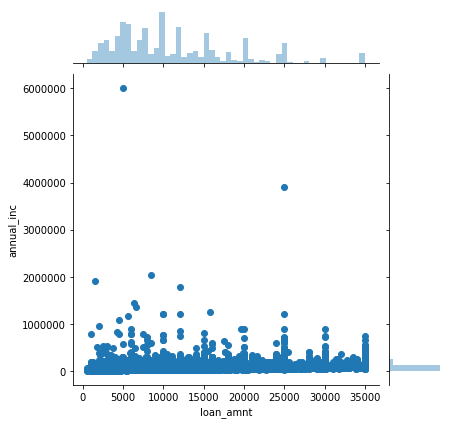

In [44]:
sns.jointplot('loan_amnt', 'annual_inc', df_loan)
plt.show()

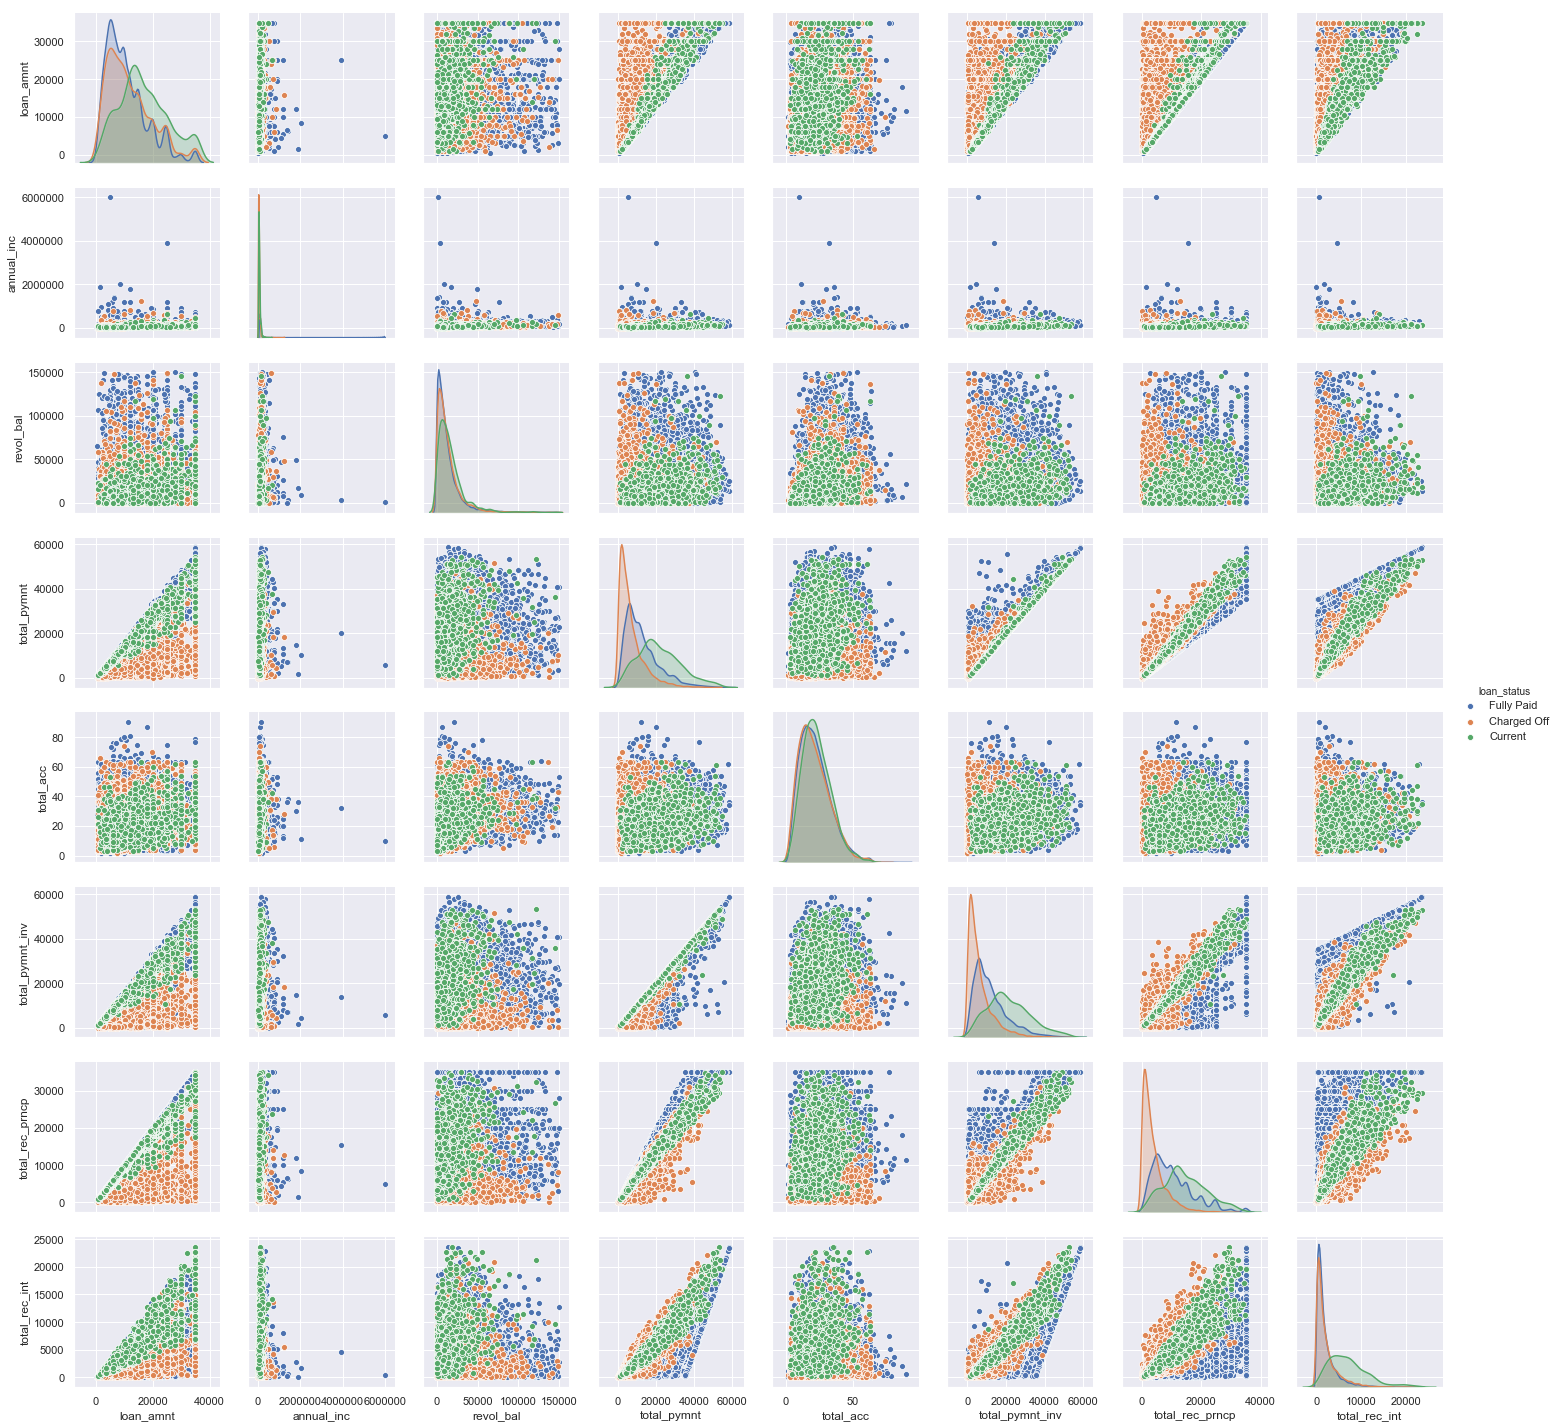

In [45]:
#Pairplot for variables
sns.set()
cols=  ['loan_amnt','annual_inc','revol_bal','total_pymnt','total_acc','total_pymnt_inv','total_rec_prncp','total_rec_int','loan_status']
sns.pairplot(df_loan[cols],height =2.5, hue = 'loan_status')
plt.show()

# Observations:
1. Most of the loans are in "Current" status
2. total_prncp_inv has a linear regression with total_pymnt
3. total_rec_prncp shoes more "Charged Off" values with loan_amnt
4. higher the annual income, the loan payment is completed
5. The total number of credit lines currently in the borrower's credit file is high for loan status = "current"
6. Principal received to date is the lowest for loan status ="Charged Off"


In [46]:
#Create Bins for range of Loan Amount
bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5K', '5K-10K', '10K-15K', '15K-20K', '20K-25K','25K+']
df_loan['loan_amnt_range'] = pd.cut(df_loan['loan_amnt'], bins, labels=slot)

In [47]:
#Create Bins for range of annual_inc
bins = [0, 25000, 50000, 75000, 100000,1000000,6000000]
slot = ['0-25K', '25K-50K', '50K-75K', '75K-100K', '100K - 1M','1M+']
df_loan['annual_inc_range'] = pd.cut(df_loan['annual_inc'], bins, labels=slot)

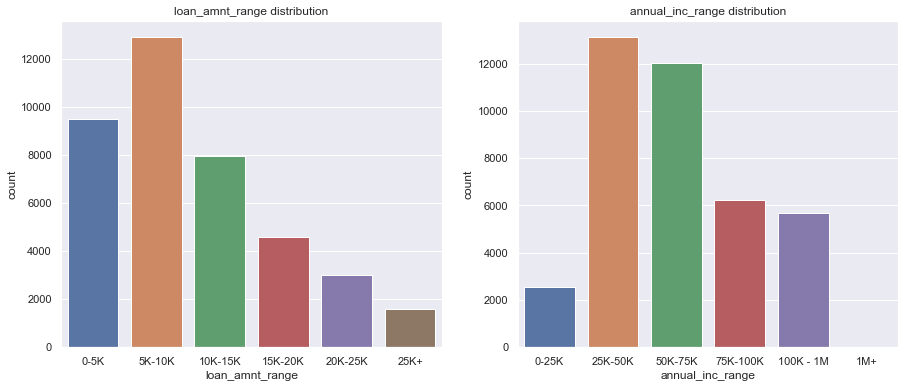

In [48]:
# Count plot on derived column
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='loan_amnt_range', data=df_loan)
plt.title("loan_amnt_range distribution")
plt.subplot(1, 2, 2)
sns.countplot(x='annual_inc_range', data=df_loan)
plt.title("annual_inc_range distribution")
plt.show()

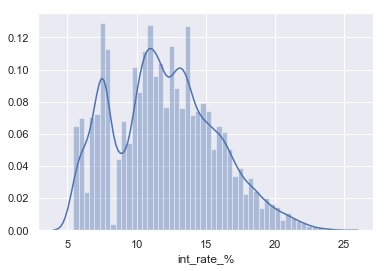

In [49]:
# simple density plot
sns.distplot(df_loan['int_rate_%'])
plt.show()

In [50]:
#Create Bins for range of Interest rate
bins = [0, 7.5, 10, 12.5, 15,20,25]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15-20','20+']
df_loan['int_rate_range_%'] = pd.cut(df_loan['int_rate_%'], bins, labels=slot)

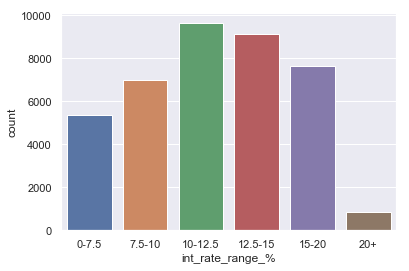

In [51]:
# Count plot on derived column
sns.countplot(x='int_rate_range_%', data=df_loan)
plt.show()

In [52]:
print("So now we are left with",df_loan.shape ,"rows & columns.")

So now we are left with (39644, 46) rows & columns.


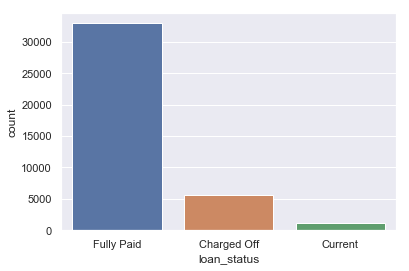

In [53]:

# Count plot on derived column
sns.countplot(x='loan_status', data=df_loan)
plt.show()


(38416, 46)

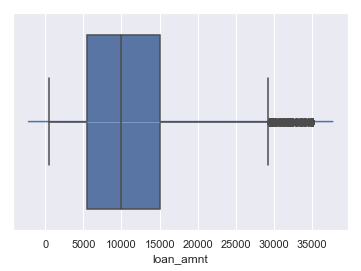

In [54]:
#finding and removing outlier for column 'funded_amnt'
sns.distplot(df_loan['loan_amnt'])
sns.boxplot(x=df_loan["loan_amnt"])
df_loan = remove_outlier(df_loan, 'loan_amnt')
df_loan.shape

(38381, 46)

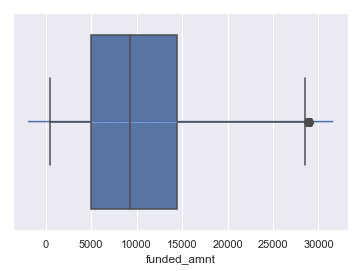

In [55]:
#finding and removing outlier for column 'funded_amnt'
sns.distplot(df_loan['funded_amnt'])
sns.boxplot(x=df_loan["funded_amnt"])
df_loan = remove_outlier(df_loan, 'funded_amnt')
df_loan.shape

(38211, 46)

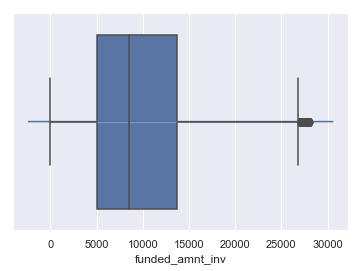

In [56]:
#finding and removing outlier for column 'funded_amnt_inv'
sns.distplot(df_loan['funded_amnt_inv'])
sns.boxplot(x=df_loan["funded_amnt_inv"])
df_loan = remove_outlier(df_loan, 'funded_amnt_inv')
df_loan.shape

(38138, 46)

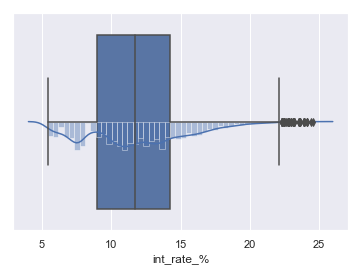

In [57]:
#finding and removing outlier for column 'int_rate_%'
sns.distplot(df_loan['int_rate_%'])
sns.boxplot(x=df_loan["int_rate_%"])
df_loan = remove_outlier(df_loan, 'int_rate_%')
df_loan.shape

(37109, 46)

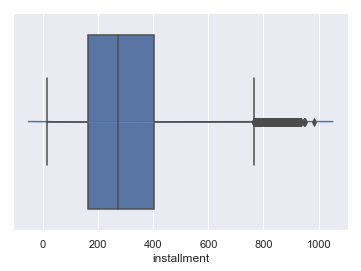

In [58]:
#finding and removing outlier for column 'installment'
sns.distplot(df_loan['installment'])
sns.boxplot(x=df_loan["installment"])
df_loan = remove_outlier(df_loan, 'installment')
df_loan.shape

(35483, 46)

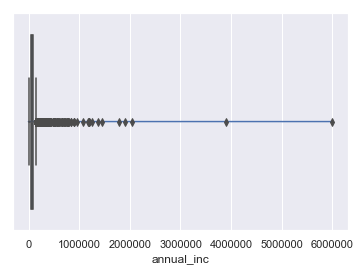

In [59]:
#finding and removing outlier for column 'annual_inc'
sns.distplot(df_loan['annual_inc'])
sns.boxplot(x=df_loan["annual_inc"])
df_loan = remove_outlier(df_loan, 'annual_inc')
df_loan.shape

(32305, 46)

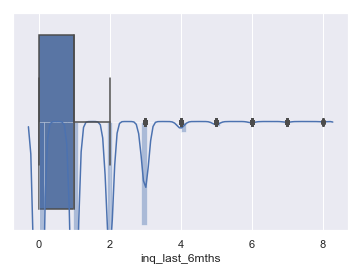

In [60]:
#finding and removing outlier for column 'inq_last_6mths'
sns.distplot(df_loan['inq_last_6mths'])
sns.boxplot(x=df_loan["inq_last_6mths"])
df_loan = remove_outlier(df_loan, 'inq_last_6mths')
df_loan.shape

(31272, 46)

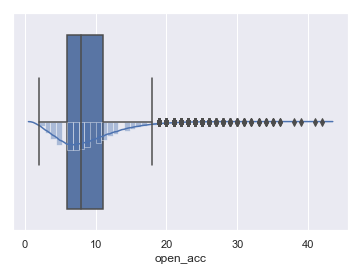

In [61]:
#finding and removing outlier for column 'open_acc'
sns.distplot(df_loan['open_acc'])
sns.boxplot(x=df_loan["open_acc"])
df_loan = remove_outlier(df_loan, 'open_acc')
df_loan.shape


(29589, 46)

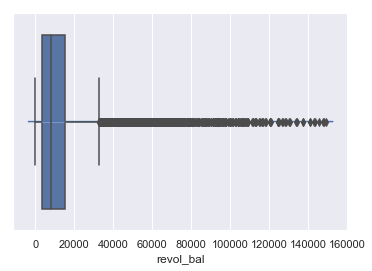

In [62]:
#finding and removing outlier for column 'revol_bal'
sns.distplot(df_loan['revol_bal'])
sns.boxplot(x=df_loan["revol_bal"])
df_loan = remove_outlier(df_loan, 'revol_bal')
df_loan.shape

(29115, 46)

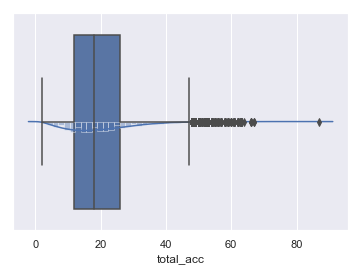

In [63]:
#finding and removing outlier for column 'total_acc'
sns.distplot(df_loan['total_acc'])
sns.boxplot(x=df_loan["total_acc"])
df_loan = remove_outlier(df_loan, 'total_acc')
df_loan.shape

(28528, 46)

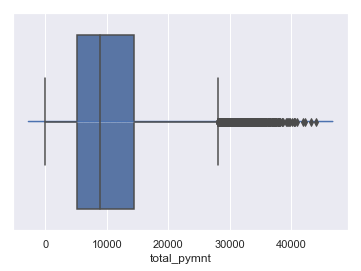

In [64]:
#finding and removing outlier for column 'total_pymnt'
sns.distplot(df_loan['total_pymnt'])
sns.boxplot(x=df_loan["total_pymnt"])
df_loan = remove_outlier(df_loan, 'total_pymnt')
df_loan.shape

(28355, 46)

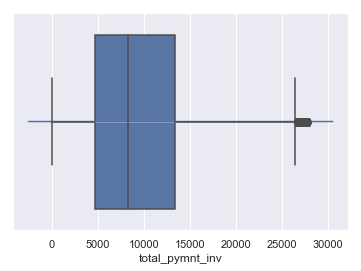

In [65]:
#finding and removing outlier for column 'total_pymnt_inv'
sns.distplot(df_loan['total_pymnt_inv'])
sns.boxplot(x=df_loan["total_pymnt_inv"])
df_loan = remove_outlier(df_loan, 'total_pymnt_inv')
df_loan.shape

(28308, 46)

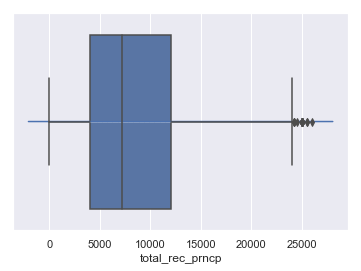

In [66]:
#finding and removing outlier for column 'total_rec_prncp'
sns.distplot(df_loan['total_rec_prncp'])
sns.boxplot(x=df_loan["total_rec_prncp"])
df_loan = remove_outlier(df_loan, 'total_rec_prncp')
df_loan.shape

(26589, 46)

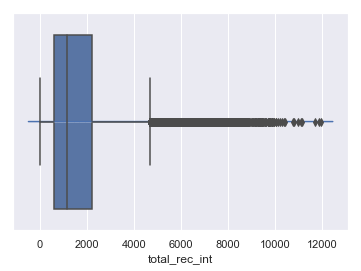

In [67]:
#finding and removing outlier for column 'total_rec_int'
sns.distplot(df_loan['total_rec_int'])
sns.boxplot(x=df_loan["total_rec_int"])
df_loan = remove_outlier(df_loan, 'total_rec_int')
df_loan.shape

(23919, 46)

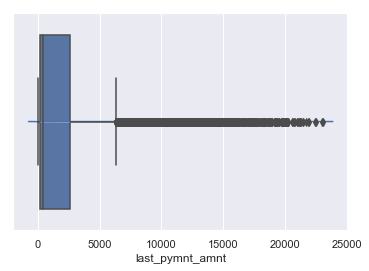

In [68]:
#finding and removing outlier for column 'last_pymnt_amnt'
sns.distplot(df_loan['last_pymnt_amnt'])
sns.boxplot(x=df_loan["last_pymnt_amnt"])
df_loan = remove_outlier(df_loan, 'last_pymnt_amnt')
df_loan.shape

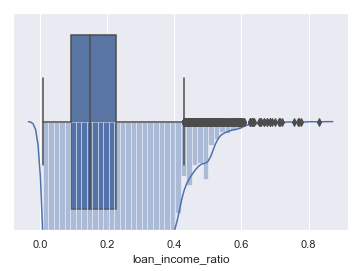

In [69]:
#finding and removing outlier for column 'loan_income_ratio'
sns.distplot(df_loan['loan_income_ratio'])
sns.boxplot(x=df_loan["loan_income_ratio"])
df_loan = remove_outlier(df_loan, 'loan_income_ratio')

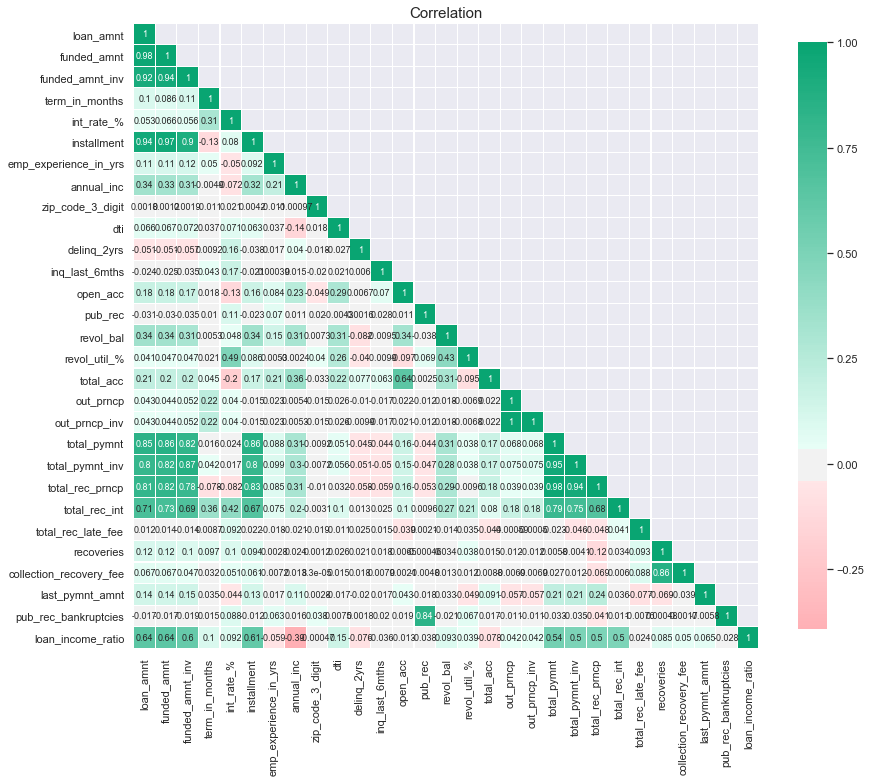

In [70]:
retained_numeric_columns= ['loan_amnt', 'funded_amnt', 'funded_amnt_inv','term_in_months', 'int_rate_%', 'installment', 'emp_experience_in_yrs',  'annual_inc','zip_code_3_digit', 'dti', 'delinq_2yrs','inq_last_6mths', 'open_acc', 'pub_rec','revol_bal', 'revol_util_%', 'total_acc', 'out_prncp', 'out_prncp_inv','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int','total_rec_late_fee', 'recoveries', 'collection_recovery_fee','last_pymnt_amnt', 'pub_rec_bankruptcies', 'loan_income_ratio' ]
correlation_heatmap(df_loan[retained_numeric_columns], 'Correlation')

# Observations

1. Remove highly correlated values
2. Based of the correlations obtained between the independent variables, dropping the following columns as they have high 
3. Correlation with the other column specified below.
4. Correlation between 'total_rec_prncp' & 'total_pymnt' : 0.98, dropping 'total_rec_prncp'.
5. Correlation between 'installment' & 'funded_amnt' : 0.97, dropping 'funded_amnt'.
6. Correlation between 'installment' & 'laon_amt' : 0.94, dropping 'installment'.
7. Correlation between 'total_pymnt' & 'total_pymnt_inv' : 0.95, dropping 'total_pymnt_inv'.
8. Correlation between 'total_pymnt' & 'laon_amt' : 0.85, dropping 'total_pymnt'.
9. Correlation between 'total_rec_int' & 'laon_amt' : 0.85, dropping 'total_rec_int'.
10. Correlation between 'collection_recovery_fee' & 'recoveries' : 0.86, dropping 'collection_recovery_fee'.
11. Correlation between 'funded_amnt_inv' & 'loan_amnt' : 0.82, dropping 'funded_amnt_inv'.
12. Correlation between 'loan_income_ratio' & 'loan_amnt' : 0.64, dropping 'loan_income_ratio'.
13. Correlation between 'out_prncp' & 'out_prncp_inv' : 1, dropping 'out_prncp_inv'.
14. Correlation between 'open_acc' & 'total_acc' : 0.64, dropping 'open_acc'


In [71]:
df_loan.drop(['total_rec_prncp', 'funded_amnt','installment', 'total_pymnt_inv','total_pymnt','open_acc','total_rec_int','collection_recovery_fee','funded_amnt_inv','loan_income_ratio','out_prncp_inv'], axis = 1, inplace = True)


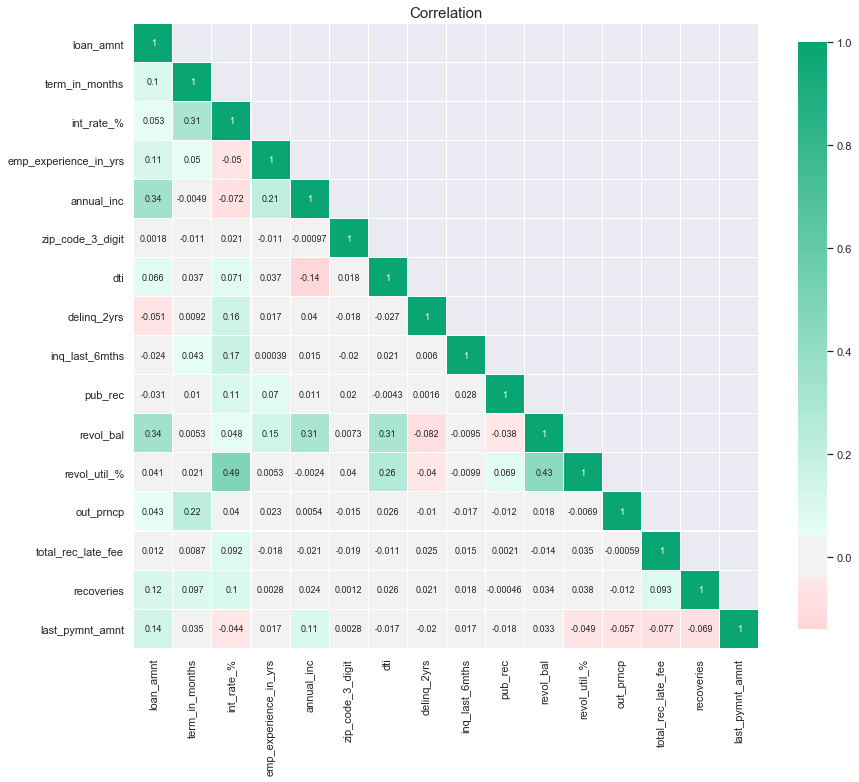

In [72]:
retained_numeric_columns= ['loan_amnt','term_in_months','int_rate_%','emp_experience_in_yrs','annual_inc','zip_code_3_digit','dti','delinq_2yrs','inq_last_6mths','pub_rec','revol_bal','revol_util_%','out_prncp','total_rec_late_fee','recoveries','last_pymnt_amnt']
correlation_heatmap(df_loan[retained_numeric_columns], 'Correlation')

In [73]:
df_loan['is_default'] = (df_loan.loan_status == 'Charged Off')

# Data Analysis and Observations

Text(0.5, 1.0, 'Information on loan default')

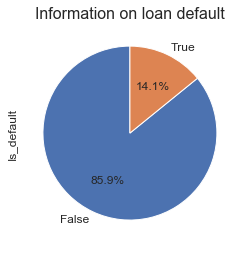

In [74]:
pie_df = pd.DataFrame(df_loan.groupby(["is_default"]).is_default.count())
pie_df.plot(kind='pie', y = 'is_default', autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=pie_df.index, legend = False, fontsize=12)
plt.ylabel("Is_default")
plt.title("Information on loan default", fontsize=16 )

``14 %`` Customer are defaulted

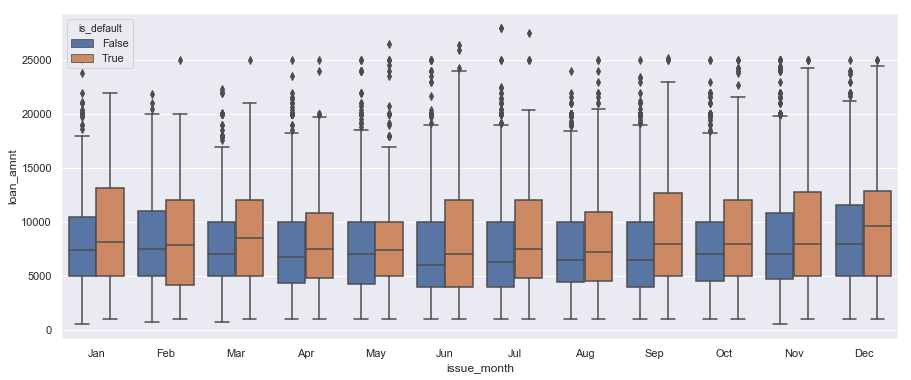

In [75]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='issue_month', y='loan_amnt', hue="is_default", data=df_loan)
plt.show()

During last quarter of the year there is more number of default customer are there when loan_amount is high

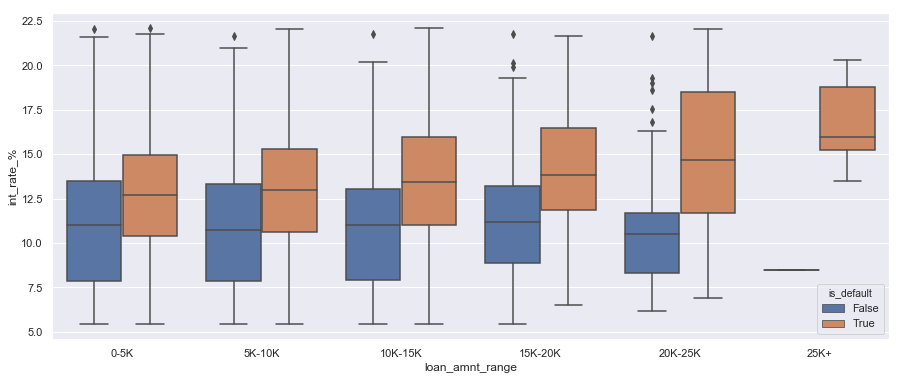

In [76]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='loan_amnt_range', y='int_rate_%', hue="is_default", data=df_loan)
#plt.yscale('log')
plt.show()

Whenever Interest rate are high more number of cusotmers were charged-off

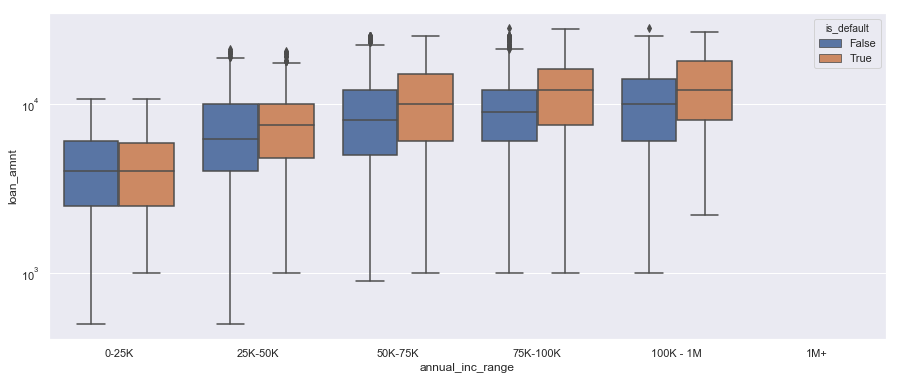

In [77]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='annual_inc_range', y='loan_amnt', hue="is_default", data=df_loan)
plt.yscale('log')
plt.show()

In [78]:
def crosstab(df,col):
    '''
    df : Dataframe
    col: Column Name
    '''
    crosstab = pd.crosstab(df[col], df['loan_status'],margins=True)
    crosstab['Probability_Charged Off'] = round((crosstab['Charged Off']/crosstab['All']),3)
    crosstab = crosstab[0:-1]
    return crosstab

In [79]:
# Probability of charge off
def bivariate_prob(df,col,stacked= True):
    '''
    df      : Dataframe
    col     : Column Name
    stacked : True(default) for Stacked Bar
    '''
    # get dataframe from crosstab function
    plotCrosstab = crosstab(df,col)
    
    linePlot = plotCrosstab[['Probability_Charged Off']]      
    barPlot =  plotCrosstab.iloc[:,0:2]
    ax = linePlot.plot(figsize=(20,8), marker='o',color = 'b')
    ax2 = barPlot.plot(kind='bar',ax = ax,rot=1,secondary_y=True,stacked=stacked)
    ax.set_title(df[col].name.title()+' vs Probability Charge Off',fontsize=20,weight="bold")
    ax.set_xlabel(df[col].name.title(),fontsize=14)
    ax.set_ylabel('Probability of Charged off',color = 'b',fontsize=14)
    ax2.set_ylabel('Number of Applicants',color = 'g',fontsize=14)
    plt.show()

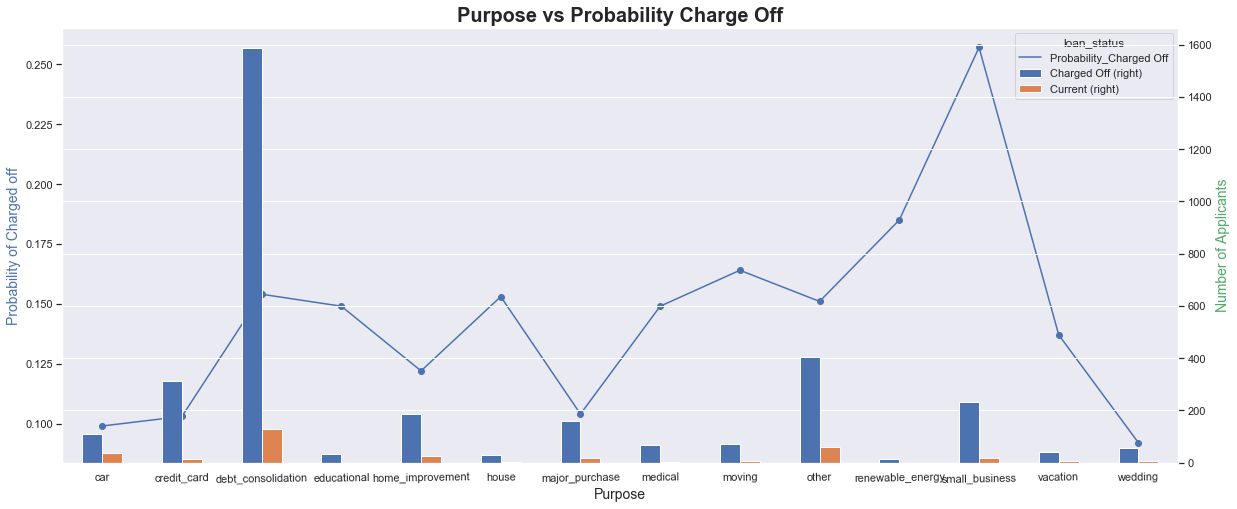

In [80]:
bivariate_prob(df =df_loan,col ='purpose',stacked=False)

For Small Business probability of charge off is high

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged Off
issue_month,,,,,
Jan,212,0,1251,2475,0.086
Feb,178,0,1261,2383,0.075
Mar,200,1,1420,2189,0.091
Apr,215,2,1521,2046,0.105
May,289,41,1508,2016,0.143
Jun,285,29,1668,2123,0.134
Jul,279,39,1805,1982,0.141
Aug,284,42,1690,1838,0.155
Sep,320,39,1687,1738,0.184


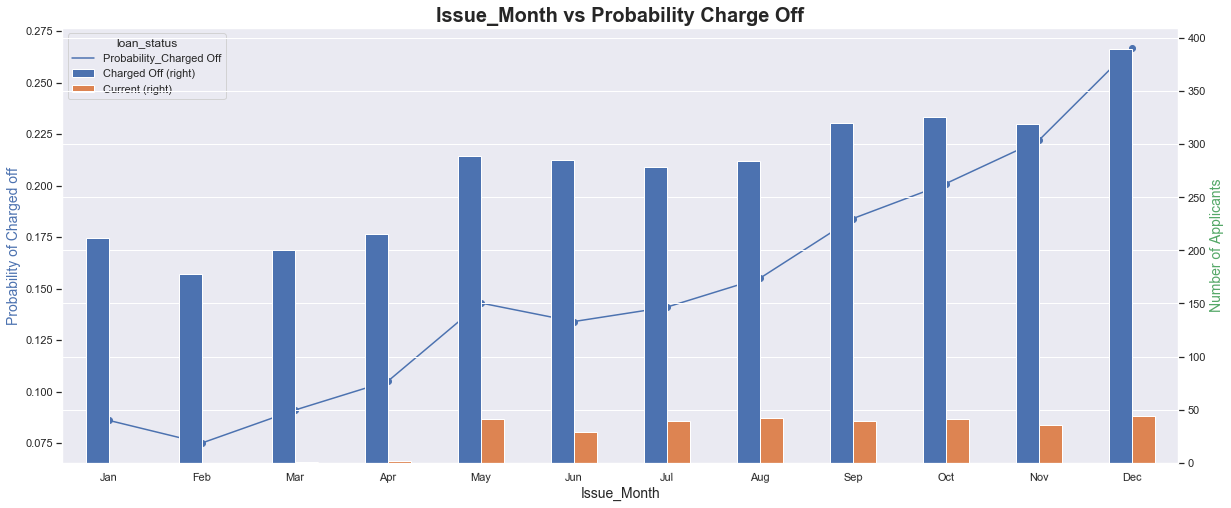

In [81]:
issue_month = crosstab(df_loan,'issue_month')
display(issue_month)
bivariate_prob(df =df_loan,col ='issue_month',stacked=False)

We are seeing a pattern on that probabilty of charge-off increase in fews months of the year
December month "Charged Off" is more as it is festive season and year end, the users may not be able to pay the loans on time.


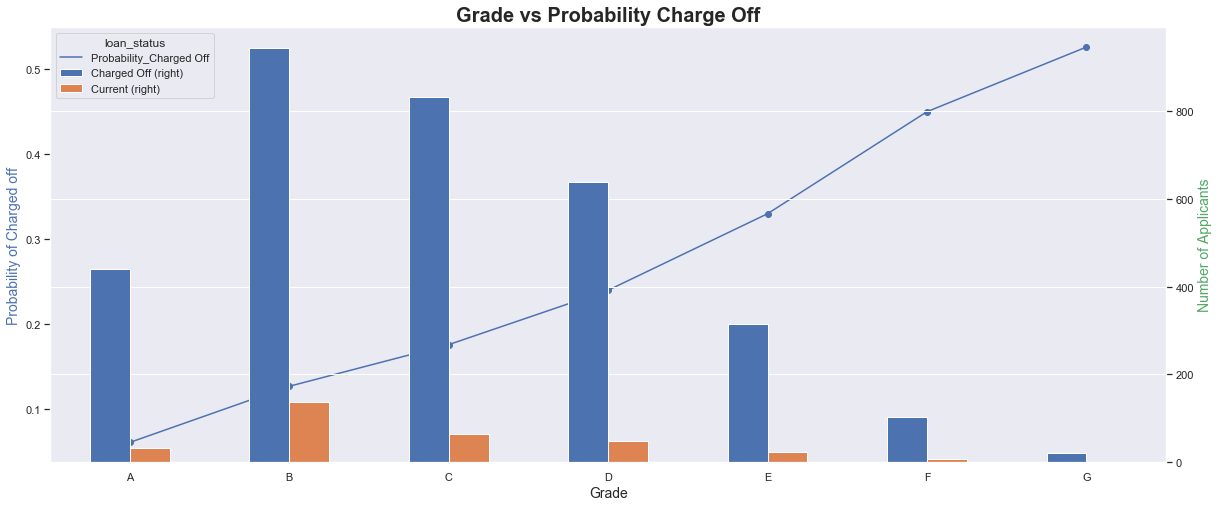

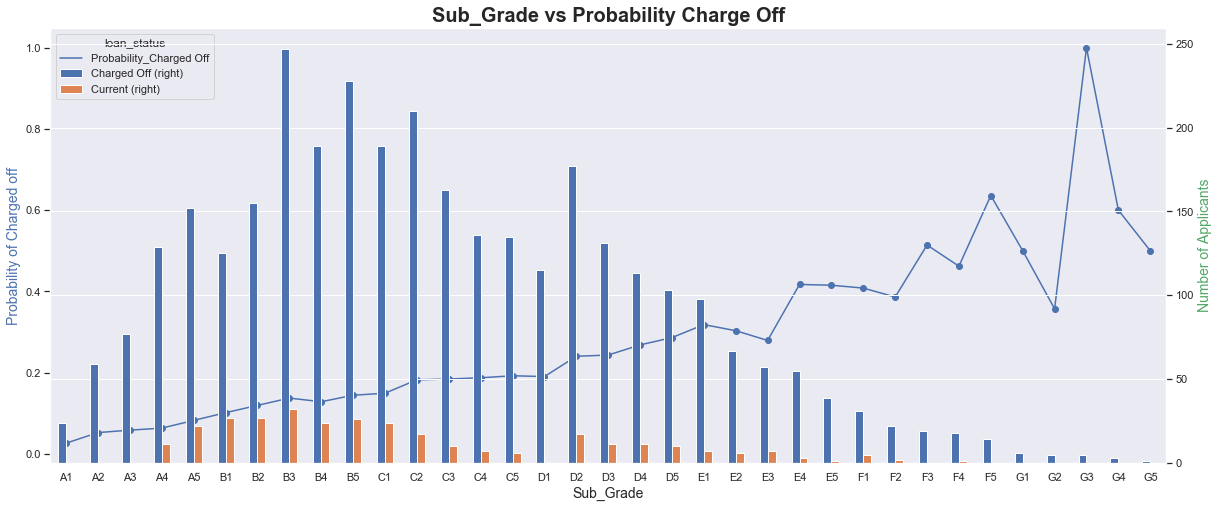

In [82]:
bivariate_prob(df =df_loan,col ='grade',stacked=False)
bivariate_prob(df =df_loan,col ='sub_grade',stacked=False)

When grade is A, B probability of charge-off is less but when it goes down chagre off probability is higher

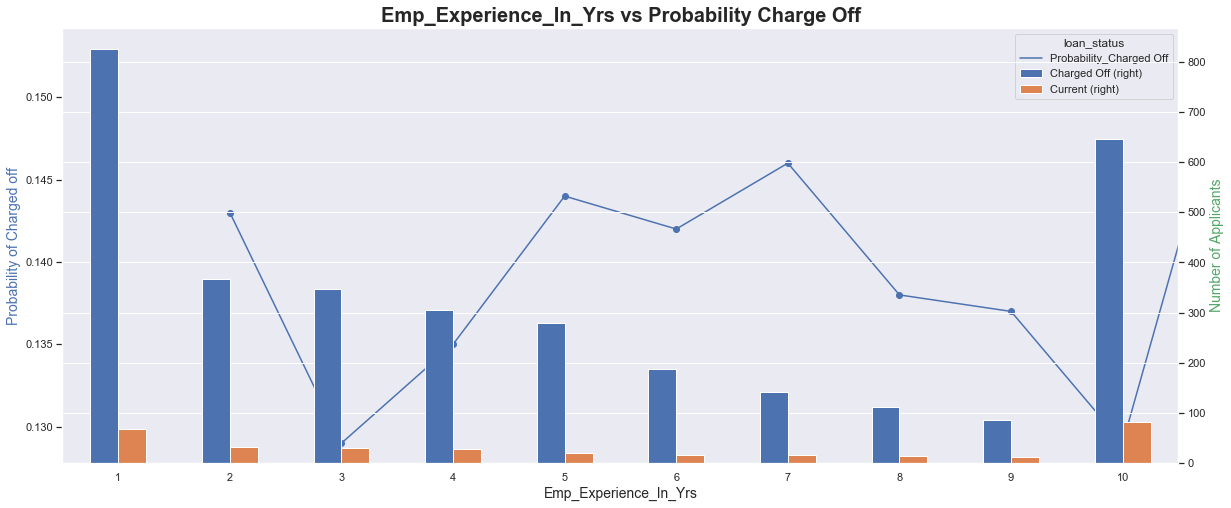

In [83]:
bivariate_prob(df =df_loan,col ='emp_experience_in_yrs',stacked=False)

Employee with less than 1 year experience are charged off as they may get lower salary followed by employee with highest experience 10+ years as they may not be able to get a job that fits in their experience.


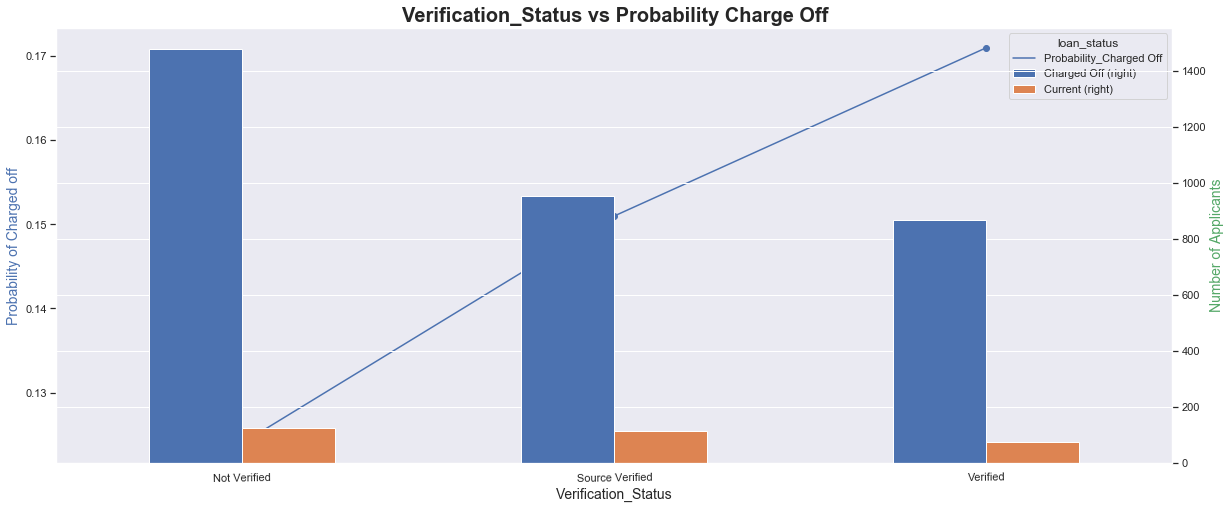

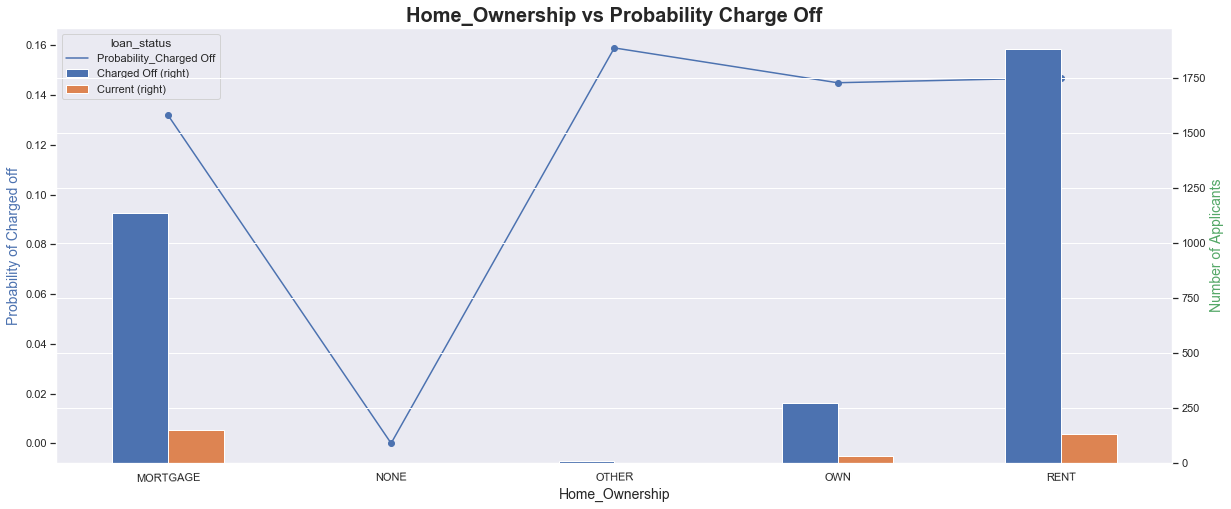

In [84]:
bivariate_prob(df =df_loan,col ='verification_status',stacked=False)
bivariate_prob(df =df_loan,col ='home_ownership',stacked=False)

Interstingly Verified customer has highest probablity of Charge-off 
In Home_ownership most of the customer applied for loan by those who were in Rent or mortage and % probability also high.

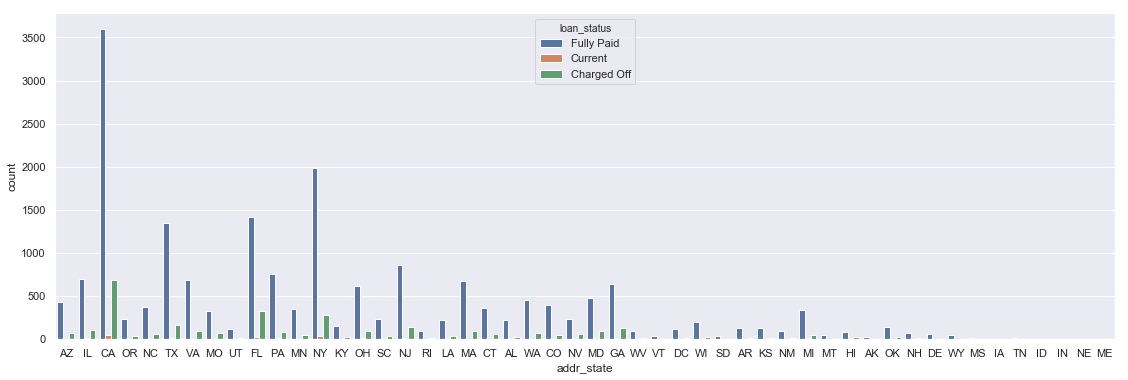

In [85]:
# Count plot on derived column
f, ax = plt.subplots(figsize=(19, 6))
sns.countplot(x='addr_state', data=df_loan, hue ='loan_status')
plt.show()

# Observation

1. State "CA" has been noticed with highest number of loan completion, followed by "NY" and "FL" states
2. "Charged Off" status is high "CA" followed by "FL" and "NY"
3. "CA" tops both the category of  "Fully Paid" and "Chared off"
4. "NY" is second top in loan completion and less compared to "FL" in "Charged Off" caetgory



# Conclusion 

1. There is a higher incidence of defaulting among customers with a bigger loan and paying a higher interest rate. So reduce monetary exposure (giving out high value loans) to customer who fall into a “high interest rate” category


2. Tendency to default remains fairly constant across income range hence the loan amount requested should be in proportion to the income


3. Among loan purposes, debt consolidation sees the highest rate of default, followed by credit card payment and small businesses. Debt consolidation may be a last ditch attempt to get back from the debt trap and most don’t succeed. Lending club should be wary of this. Credit card repayment also falls into the same category in general. 1 out of 10 small business venture succeed. Lending-club has to study the potential of the borrower.


4. Incidence of charge-off is higher in the last quarter of the year.
December being the close of FY (in US), incidence of loan write-off is more in the last quarter of the year and spikes in the last month. Limit the loan dispersement towards end of the year as the defaulters are more. 

5. Probability of default/charge-off increases with load ‘grade’. So Limit exposure to applicants who would fall into a higher ‘grade’. Increase exposure to loans that fall into Grade A or B 


6. Employee number of years of experience has no bearing of probability of charge off. Hence for lesser experienced or freshers the loan can be limited. 

7. Certain states have a higher incidence of defaults. Perhaps due to the higher cost of living in California, Florida and New York, there are higher incidents of write-offs in these states. Limit exposure to applications from this state. Vet the applicant thoroughly before providing loans to applicants from these states.
